In [16]:
import os
import json
import datetime as dt
import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, SelectFromModel, chi2, RFE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn import metrics

In [2]:
pd.options.display.max_columns = 80
pd.options.display.float_format = lambda x : "{:,.2f}".format(x)

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12,8)

In [3]:
train = pd.read_csv('clean_data/train.csv', dtype={'Id':str})
test = pd.read_csv('clean_data/test.csv', dtype={'Id':str})

train.shape, test.shape

((15120, 54), (565892, 55))

In [4]:
all_train_df = pd.read_csv('clean_data/all_train_df.csv', dtype={'Id':str})
all_test_df = pd.read_csv('clean_data/all_test_df.csv', dtype={'Id':str})

train.shape, test.shape

((15120, 54), (565892, 55))

In [5]:
with open('clean_data/train_cols.json', 'r') as f:
    train_cols = json.load(f)

In [6]:
id_col = train_cols['id']
cat_cols = train_cols['cat_cols']
int_cols = train_cols['int_cols']
target_col = train_cols['target_col']

ftr_cols = int_cols + cat_cols

In [7]:
ytrain = train[target_col]

In [15]:
N = 35 # nfeatures
seed = 1111

### Goal

Build a function that performs various kinds of features selection on input dataset.

This function will be used in modeling notebook.

Methods:
    - Correlations
    - Chi2
    - RFE
    - Lasso
   

___Correlation___

In [41]:
def top_corr(x,y,n):
    """
    x Dataframe
    y Series or array
    
    Returns series of ftr, score for top n most correlated features
    Score is calculated the sum of abs correlations for all classes
    """
    
    class_dummies = pd.get_dummies(y).add_prefix('class_')
    corrs = []
    for col in x.columns:
        corrs.append(class_dummies.apply(lambda c: c.corr(x[col])).abs().sum())
    
    ret = pd.DataFrame([corrs],columns=x.columns).T.squeeze().nlargest(n)
    # standardize
    ret = ret = (ret-ret.min())/(ret.max()-ret.min())
    ret.name = 'corrs'
    
    return ret

___Chi2___

In [43]:

def top_chi2(x, y, n):
    """
    x Dataframe
    y Series/Array -- class labels
    n Int
    """

    features = x.columns

    # all features must be positive
    x_norm = MinMaxScaler().fit_transform(x)

    selector = SelectKBest(chi2, k=n)
    selector.fit(x_norm, y)
    # bool index on selected columns
    selected = selector.get_support()

    chi2_scores = pd.DataFrame(list(zip(features, selector.scores_)), columns=['ftr', 'chi2_score'])
    chi2_ftrs = chi2_scores.loc[selected]

    ret = chi2_ftrs.sort_values('chi2_score', ascending=False).head(n).set_index('ftr').squeeze()
    ret = (ret-ret.min())/(ret.max()-ret.min())
    return ret

___RFE___

In [13]:
def top_rfe(mod, x, y, n, step=0.05, **params):
    selector = RFE(mod(**params), n, step, 1)
    selector.fit(x, y)
    selected = selector.get_support()
    
    rfe_ftrs = np.asarray(x.columns)[selected]
    rfe_ftrs = pd.Series(1, index = rfe_ftrs)
    return rfe_ftrs

___Lasso___

In [45]:

def top_lasso(x,y,n,step=0.1, verbose=0):
    xscaled = MinMaxScaler().fit_transform(x.values)
    C = n/xscaled.shape[1]

    direction='down'
    num_non_zero = xscaled.shape[1]
    while num_non_zero != N:
        if verbose:
            print("Fitting Lasso with C =",C)
        l = LogisticRegression(penalty='l1', C=C)
        l.fit(xscaled, y)
        mask = l.coef_.mean(0)!=0
        num_non_zero = mask.sum()
        if verbose:
            print('Num Non-Zero Features:', num_non_zero)
        if num_non_zero == N:
            ret = pd.Series(np.abs(l.coef_).mean(0)[mask], index = x.columns[mask])
            ret.name='l1'
            ret = (ret-ret.min())/(ret.max()-ret.min())
            return ret
        elif num_non_zero > N:
            C *= 1-step
            new_direction = 'down'
        else:
            C *= 1+step
            new_direction = 'up'
        
        # if we change direction (overshot) lower step
        if new_direction != direction:
            step*=0.5
            direction=new_direction
            if verbose:
                print('New Step:', step)


In [ ]:
rf_params = {'n_estimators': all_train_df.shape[1]-1, 'max_features':N, 'n_jobs':-1, 'random_state':seed}
gb_params = {'n_estimators': all_train_df.shape[1]-1, 'random_state':seed}


In [66]:
def run_ftr_selection(X, Y, n, rf_params, gb_params):

    top_corrs = top_corr(X, Y, n)
    topchi2 = top_chi2(X, Y, n)

    print('Fitting LogReg')
    rfe_lreg_ftrs = top_rfe(LogisticRegression, X, Y, n, 0.1)
    print()
    print('Fitting RF')
    rfe_rf_ftrs = top_rfe(RandomForestClassifier, X, Y, n, 0.1, **rf_params)
    print()
    print('Fitting GB')
    rfe_gb_ftrs = top_rfe(GradientBoostingClassifier, X, Y, n, 0.1, **gb_params)

    l1_ftrs = top_lasso(X, Y, n, 0.5, verbose=1)
    
    all_scores = [top_corrs, topchi2, rfe_lreg_ftrs, rfe_rf_ftrs, rfe_gb_ftrs, l1_ftrs]
    
    
    all_scores = pd.concat(all_scores, axis=1)
    all_scores.columns = ['corrs','chi2', 'rfe_lreg', 'rfe_rf', 'rfe_gb', 'l1']
    
    return all_scores.sum(1).nlargest(N)

In [68]:
usecols = all_scores.sum(1).nlargest(N)
usecols

nb_prob_6                            5.57
nb_prob_3                            5.20
nb_prob_0                            4.75
nb_prob_4                            4.61
Elevation                            4.61
nb_prob_2                            4.59
nb_prob_1                            4.51
nb_prob_5                            4.49
pca0                                 3.98
svd1                                 3.96
Horizontal_Distance_To_Roadways      3.48
pca1                                 3.32
svd2                                 3.26
Horizontal_Distance_To_Fire_Points   3.25
Hillshade_Noon                       3.22
Hillshade_9am                        3.05
svd5                                 3.04
pca8                                 3.04
svd6                                 3.04
pca4                                 3.03
Horizontal_Distance_To_Hydrology     3.00
Vertical_Distance_To_Hydrology       3.00
pca2                                 3.00
pca9                              

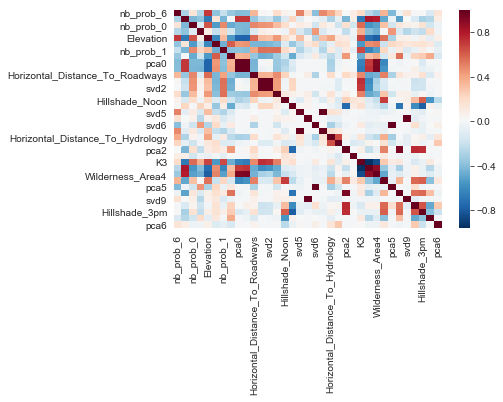

In [70]:
sns.heatmap(all_train_df[usecols.index].corr(), cmap = 'RdBu_r')